# Final Project - CIS5200

The Goal of this project is to predict the chess board positions based on Images. The labels are present in the form of ***FEN Notation***.

## Importing the Necessary Libraries

In [1]:
import random 
import pandas as pd
import sys
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
import glob
import re
import cv2
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")      
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from PIL import Image

## Configuring Kaggle

Install `kaggle` package to download the data directly into the notebook. Then create a `.kaggle` directory in the `home` folder.

In [2]:
! pip install kaggle
! mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Upload your `kaggle.json` file obtained from Kaggle. To create this file, go to `Account` -> `Create New API Token`. Reference Link to the whole Procedure : https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Getting the Data

Download the dataset from Kaggle.

In [5]:
! kaggle datasets download koryakinp/chess-positions

100% 4.01G/4.01G [02:01<00:00, 35.9MB/s]
100% 4.01G/4.01G [02:01<00:00, 35.3MB/s]


In [6]:
! unzip chess-positions.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/b1K5-6rB-5k2-5r2-1b6-8-5n2-8.jpeg  
  inflating: train/b1K5-8-3k4-3p4-8-3B1r2-1b6-4N3.jpeg  
  inflating: train/b1K5-8-8-2p3p1-5k2-8-8-7R.jpeg  
  inflating: train/b1K5-8-8-8-2qr1N2-8-6nk-3b4.jpeg  
  inflating: train/b1K5-r7-4kb2-R4Q1p-b7-1pb5-5P2-8.jpeg  
  inflating: train/b1KB4-2B5-3p4-1BB5-3k1n2-p1r5-2n5-5r1q.jpeg  
  inflating: train/b1Kb4-6P1-n2Q3k-8-4N1n1-2b2P2-8-8.jpeg  
  inflating: train/b1Kr4-8-q7-8-1bB5-8-2k1P1RR-8.jpeg  
  inflating: train/b1Kr4-P7-R2R4-1b3B2-3Pr3-4Nk2-8-4R3.jpeg  
  inflating: train/b1N1k3-K1q5-1P1B4-2R5-3N3Q-3brP2-8-1B1n4.jpeg  
  inflating: train/b1N1n1q1-R5RQ-1N2r2P-3n4-3k4-8-3n3N-K7.jpeg  
  inflating: train/b1N1qn2-1P5k-b3K1p1-8-2B4n-7N-5B2-1b2B3.jpeg  
  inflating: train/b1N1r1k1-2R5-1r2b3-5KpR-N1P5-8-6R1-7B.jpeg  
  inflating: train/b1N1r3-2P1r1k1-3b4-8-3K3b-2rB4-7p-8.jpeg  
  inflating: train/b1N2K1b-2Bp4-4B2k-b2p4-8-7n-3p3n-2B2B2.jpeg  
  inflating: train/b1N2b1R-3n4-P2P4-1n2K

## Understanding the Data

In [7]:
train_path = glob.glob("./dataset/train/*.jpeg")
test_path = glob.glob("./dataset/test/*.jpeg")

In [8]:
def get_fen_from_path(path_to_img):
    # Remove everything before the second `/`, including the `/`.
    final_str = path_to_img[path_to_img.rfind('/')+1:]
    # Remove `.jpeg`
    return final_str[:-5]

In [9]:
print(train_path[15])
print(get_fen_from_path(train_path[15]))
print("")
print(test_path[15])
print(get_fen_from_path(test_path[15]))

./dataset/train/Kr5b-7r-2n1k3-2pp1p2-8-8-RR1Rb3-2R1n3.jpeg
Kr5b-7r-2n1k3-2pp1p2-8-8-RR1Rb3-2R1n3

./dataset/test/5N2-nq1P3n-8-2b1kb1n-B6b-K1R5-8-2q5.jpeg
5N2-nq1P3n-8-2b1kb1n-B6b-K1R5-8-2q5


### Encoding and Reconstructioin of the FEN Notation
The FEN notation is now converted to a 64 x 13 matrix that represents the position of each piece on the board based on the FEN label. Each `row` consists of 13 columns, with every column representing one of the 6 pieces in `black` and
`white` camp. Finally the last column denotes if that square is empty.


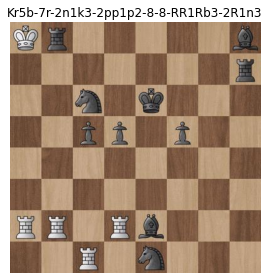

In [10]:
img_rand=cv2.imread(train_path[15])
plt.imshow(cv2.cvtColor(img_rand, cv2.COLOR_BGR2RGB))
plt.title(get_fen_from_path(train_path[15]))
plt.axis('off')
plt.tight_layout()
plt.show()

To understand this better let's take an example : `2b4B-2b1b3-5p1r-6R1-3K4-4Pr2-1pN1k3-3Nr3`. This is the label/position
for the state of the chess board shown above. The description for each row is separated using the `-` delimiter in the string. So, the first element (which is `2b4B`) in the FEN string describes the first row. Let's dissect this further. Here, `2` says that the first couple squares in the first row are empty which is be validated by the image. Then the `b` letter states that there is a ***Black Bishop*** on the 3rd square in the first row. Note that lower case letters are used to represent the ***black*** pieces, and the uppercase letters are used to represent the ***white*** pieces. Then, the number `4` again says that there are four empty squares after the black bishop. Finally, a `B` says that there is a white bishop present. If you notice, we have traversed and sucessfully encoded all the 8 squares of the first row. In the exact same manner all the other rows of the board are encoded.

Now that we understand the FEN notation used here, we need to encode this with numbers to train our model.

In [11]:
# Columns in the encoded matrix.
#         Black        |          White        |  Empty
#      b k n p q r     |       B K N P Q R     |    _
piece_list = np.array(['b', 'k', 'n', 'p', 'q', 'r',
                       'B', 'K', 'N', 'P', 'Q', 'R',
                       'empty'])

def fen_to_matrix(fen_label):
  # Initialize the Encoded Matrix.
  encoded_mat = np.zeros((64,13))
  # Row Pointer to keep track of the current row in the matrix.
  row_pointer = 0
  # Iterate over each of the letters in the `fen_label`. 
  for letter in fen_label:
    # Continue without doing anything, if the `-` delimiter is
    # found.
    if letter == '-':
      continue
    else:
      # Get the index for the current letter in the `piece_list`.
      piece_idx = np.argwhere(piece_list == letter)
      # Check if the current element is a letter or a number.
      if len(piece_idx) != 0:
        encoded_mat[row_pointer, piece_idx] = 1
        row_pointer += 1
      else:
        # If the element was a number, type cast it to an `int`.
        # Then set the empty column in the rows for that number
        # of rows.
        for i in range(int(letter)):
          encoded_mat[row_pointer, 12] = 1
          row_pointer += 1
  
  # Flatten the matrix
  encoded_mat = encoded_mat.reshape((encoded_mat.shape[0] * encoded_mat.shape[1],))

  return encoded_mat

In [12]:
def reconstruct_fen(encoded_mat):
  encoded_mat_copy = encoded_mat.copy()
  encoded_mat_copy = encoded_mat_copy.reshape((64, 13))
  n,p = encoded_mat_copy.shape
  # Create an empty array for the fen label.
  fen_label = []
  # Initialize a counter variable that counts 
  # the number of empty spots.
  empty_count = 0
  # Iterate over all `64` rows.
  for i in range(n):
    # Append a `-` if 8 squares are done.
    if (i) % 8 == 0 and i != 0:
      fen_label.append('-')
    # Check if the square is empty.
    if encoded_mat_copy[i, 12] == 1:
      # If the square is empty check if the next square is also empty
      # or if we are switching to the next row. If not, append the
      # `empty_count` to the `fen_label` and set `empty_count` to `0`.
      # Otherwise, just keep updating `empty_count`.
      if (i < n-1 and encoded_mat_copy[i+1, 12] != 1) or ((i+1) % 8 == 0):
        fen_label.append(str(empty_count+1))
        empty_count = 0
      else:
        empty_count += 1
    # If the square is not empty, find the piece that is present in that
    # row. Based on that append the letter denoting that piece to `fen_label`.
    else:
      piece_idx = np.argwhere(encoded_mat_copy[i] == 1).reshape(-1).item()
      fen_label.append(piece_list[piece_idx])
  
  # Finally convert the whole array into a string. We finally have our FEN
  # reconstructed now.
  fen_label = "".join(fen_label)
  return fen_label

In [13]:
reconstructed_fen_notation = reconstruct_fen(fen_to_matrix(get_fen_from_path(train_path[20])))

if reconstructed_fen_notation == get_fen_from_path(train_path[20]):
  print("Matched")

Matched


## Loading the Data
References : 

*   https://www.youtube.com/watch?v=NVxCKdp0NhQ
*   https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



In [14]:
train_data_size = 8000
test_data_size = 2000

def load_data(data_path, data_size):
  data_ = []
  data_labels = []
  for i in range(data_size):
    curr_img = np.array(Image.open(train_path[i]).convert('L'))
    # curr_img = cv2.imread(train_path[i])
    # curr_img = cv2.resize(curr_img, (240,240))
    # curr_img = cv2.cvtColor(curr_img, cv2.COLOR_BGR2GRAY)
    # curr_img = cv2.normalize(curr_img, curr_img,  0, 255, cv2.NORM_MINMAX)
    data_.append(curr_img)
    data_labels.append(fen_to_matrix(get_fen_from_path(train_path[i])))
  
  return np.array(data_), np.array(data_labels)

X_train, y_train = load_data(train_path, train_data_size)
X_test, y_test = load_data(test_path, test_data_size)

In [ ]:
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [15]:
print(X_train.shape)
print(y_train.shape)
print("")
print(X_test.shape)
print(y_test.shape)

(8000, 400, 400)
(8000, 832)

(2000, 400, 400)
(2000, 832)


In [16]:
from torch.utils.data import Dataset, DataLoader

class Chess_Datatset(Dataset):
  def __init__(self, X, y, transform=None):
    self.dataset = X
    self.labels = y
    self.transform = transform
    # self.dataset = torch.tensor(self.df).float()
    # self.labels = torch.tensor(self.df_labels).float()
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    img = Image.fromarray(self.dataset[idx], mode='L')
    if self.transform:
      img = self.transform(img)
    return img, self.labels[idx]

In [17]:
mean = 0.5
std = 0.5

transformation = transforms.Compose([transforms.Resize(240),
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean,), (std,))
                                    ])

In [18]:
X_train_new = X_train.copy()
print(X_train_new.shape)

train_data = Chess_Datatset(X_train_new, y_train, transform=transformation)
train_data
# image, labels = train_data.__getitem__(0)
# print(np.array(image).shape)
# print(np.array(labels).shape)

(8000, 400, 400)


In [19]:
X_test_new = X_test.copy()
print(X_test_new.shape)

# N, H, W, C -> N, C, H, W

test_data = Chess_Datatset(X_test_new, y_test, transform=transformation)
test_data

(2000, 400, 400)


In [20]:
train_data_loader = DataLoader(train_data, batch_size=4, num_workers=2,
                               shuffle=True, drop_last=False)
test_data_loader = DataLoader(test_data, batch_size=4, num_workers=2,
                              shuffle=True, drop_last=False)

## CNN Architecture

In [21]:
import torch.nn as nn
import torch.nn.functional as F

#(w-k+2p)/s + 1 = 240, 120, 120, 60

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=11, stride=3, padding=2)
        self.relu = torch.nn.ReLU()
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv_2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, stride=2, padding=2)
        self.relu = torch.nn.ReLU()
        self.max_pool2d_1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.dropout = torch.nn.Dropout(p=0.5)
        
        self.linear_1 = torch.nn.Linear(9 * 9 * 32, 2048)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(2048, 832)
        
    def forward(self, x):

        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)

        x = self.relu(self.conv_2(x))
        x = self.max_pool2d_1(x)

        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)

        return x

## Training Our CNN

In [22]:
import torch.optim as optim

model = Net()
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss = []
# training iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(train_data_loader):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 1, loss: 636673.4878
epoch: 2, loss: 618243.5800
epoch: 3, loss: 603116.8088
epoch: 4, loss: 597522.6844
epoch: 5, loss: 592945.4745
epoch: 6, loss: 588858.5748
epoch: 7, loss: 584962.3899
epoch: 8, loss: 580959.5049
epoch: 9, loss: 577806.9209
epoch: 10, loss: 575488.0616


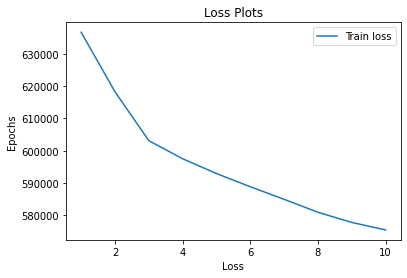

In [23]:
fig=plt.figure()
plt.plot(np.arange(1, epochs+1), train_loss, label="Train loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for itr, (image, label) in enumerate(test_data_loader):
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(label.reshape(len(label),)).sum() 
        total += float(len(label))
    accuracy = correct / total
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

RuntimeError: ignored